In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')
from utils.implementation_utils import *
from utils.preprocessing_utils import *
import datetime
from model import *
%load_ext autoreload
%autoreload 2

In [44]:
def test(w, X_test, y_test):
    y_pred = predict_labels(w, X_test)
    y_test[np.where(y_test <= 0)] = -1
    accuracy = get_accuracy(y_pred, y_test)
    print(f'Model accuracy: {accuracy}')
    return accuracy

def reg_logistic_regression_(y, tx, lambda_ , initial_w, max_iters, gamma):
    w = initial_w
    ws_list = []
    for iter in range(max_iters):
        loss, grad = penalized_logistic_regression(y, tx, w, lambda_)
        w = w - gamma * grad
        if (iter % 100 == 0):
            ws_list.append(w)
    return w, loss, ws_list

def train_(X, y, rmv_idx, method=reg_logistic_regression_, max_iters=800, gamma=1e-7, lambda_=1e-8, batch_size=1,
          start_degree=-3, end_degree=8, include_half=True, include_cross_terms=True):

    if method == reg_logistic_regression_:
        w, loss, ws_list = reg_logistic_regression_(
            y=y,
            tx=X,
            lambda_=lambda_,
            initial_w=np.zeros(X.shape[1]),
            max_iters=max_iters,
            gamma=gamma,
        )
    elif method == ridge_regression:
        w, loss = ridge_regression(y, X, lambda_=1e-8)
    else:
        raise ValueError('Please specify valid method name')

    logger.info(f'Final loss value for trained model: {loss}')

    # for i in rmv_idx:
    #     w = np.insert(w, i, 0)

    return w, loss, ws_list


def run_model_split_(save_weights=False, retrain=True, internal_test=True, create_submission=False, add_bias_term=True,
                    apply_cross_validation=True):
    y, X, Xt, ids = load_csv_data('../data/train.csv')
    print('Data shape: ', y.shape, X.shape)
    X_list, y_list, rmv_idx_list = preprocess_train_data_split(X, y)  # doesn't do any train / test splitting
    ws = []
    losses = []
    train_acc_list_all = []
    test_acc_list_all  = []
    for i, (y, X, rmv_idx), in enumerate(zip(y_list, X_list, rmv_idx_list)):
        if add_bias_term:
            X = np.concatenate((np.ones(X.shape[0])[:, np.newaxis], X), axis=1)
        w_split = []
        losses_split = []
        if apply_cross_validation:
            k_fold = 10
            k_indices = build_k_indices(y, k_fold)
        else:
            k_fold = 1
        for k in range(1):
            start_time = datetime.now()
            if apply_cross_validation:
                X_train, y_train, X_test, y_test = split_cross_validation(y, X, k_indices, k)
                y_train_dist = np.asarray((np.unique(y_train, return_counts=True))).T
                y_test_dist = np.asarray((np.unique(y_test, return_counts=True))).T
                # with np.printoptions(precision=0, suppress=True):
                #    print(f'y_train distribution: {y_train_dist} \ny_test distribution: {y_test_dist}')
            else:
                X_train, y_train = X, y

            if not retrain:
                w = np.loadtxt('sgd_model.csv', delimiter=',')
            else:
                if apply_cross_validation:
                    current_config = get_run_configs(k=k_fold)[k]
                    print(f'Training with config: {current_config}')
                    w, loss, ws_list = train_(X_train, y_train, rmv_idx, max_iters=20000)
                else:
                    w, loss = train(X_train, y_train, rmv_idx)
                losses_split.append(loss)
                w_split.append(w)
                end_time = datetime.now()
                exection_time = (end_time - start_time).total_seconds()
                print("Model training time={t:.3f} seconds".format(t=exection_time))

            if internal_test and apply_cross_validation:
                print(f'Test for datasplit : {i} and k {k}')
                train_acc_list = []
                test_acc_list  = []
                for w_ in ws_list:
                    train_acc_list.append(test(w_, X_train, y_train))
                    test_acc_list.append(test(w_, X_test, y_test))
        train_acc_list_all.append(train_acc_list)
        test_acc_list_all.append(test_acc_list)
        
    return train_acc_list_all, test_acc_list_all

In [ ]:
train_acc_list_all, test_acc_list_all = run_model_split_()

Data shape:  (250000,) (250000, 30)
Removed features indexes :  [ 4  5  6  8 12 22 23 24 25 26 27 28 29]


In [35]:
print(train_acc_list_all, test_acc_list_all)

[[73.90651586427785, 77.84672872251693, 79.34919205062334, 80.0754011944083, 80.48577052680746, 80.72932305741834, 80.85054326671782, 80.9561939078504, 81.02180851655379, 81.06629299703066, 81.0940957973287, 81.11522592555522, 81.13524394176982, 81.15748618200826, 81.18195264627053, 81.19863432644937, 81.21420389461626, 81.23310979881894, 81.24423091893816, 81.24979147899776, 81.2564641510693, 81.26313682314083, 81.26424893515275, 81.26313682314083, 81.26869738320043, 81.2720337192362, 81.27981850331966, 81.2820427273435, 81.28871539941503, 81.28649117539119, 81.28649117539119, 81.28982751142695, 81.29872440752233, 81.29983651953425, 81.30317285557001, 81.30317285557001, 81.30650919160578, 81.3076213036177, 81.3076213036177, 81.30984552764154, 81.30984552764154, 81.30984552764154, 81.31206975166539, 81.31318186367731, 81.31429397568922, 81.31429397568922, 81.31540608770115, 81.31429397568922, 81.31651819971307, 81.31985453574885], [69.44802682486458, 72.28383916544865, 73.3829134783480

In [25]:
y, X, Xt, ids = load_csv_data('../data/train.csv')

In [36]:
X_list, y_list, _ = subdivide_data(X, y)
train_acc = (np.array(train_acc_list_all[0]) * X_list[0].shape[0] 
             + np.array(train_acc_list_all[1]) * X_list[1].shape[0]
             + np.array(train_acc_list_all[2]) * X_list[2].shape[0]
             + np.array(train_acc_list_all[3]) * X_list[3].shape[0]) / X.shape[0]
test_acc = (np.array(test_acc_list_all[0]) * X_list[0].shape[0] 
             + np.array(test_acc_list_all[1]) * X_list[1].shape[0]
             + np.array(test_acc_list_all[2]) * X_list[2].shape[0]
             + np.array(test_acc_list_all[3]) * X_list[3].shape[0]) / X.shape[0]

In [43]:
print(test_acc.shape)

(50,)


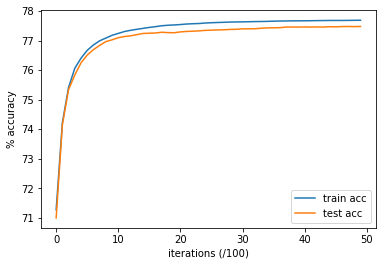

In [42]:
# plot lines
x = np.arange(0, train_acc.shape[0])
plt.plot(x, train_acc, label = "train acc")
plt.plot(x, test_acc, label = "test acc")
plt.xlabel('iterations (/100)')
plt.ylabel('% accuracy')
#plt.plot(x, accuracy[2], label = "line 3")
plt.legend()
plt.savefig('../figs/accuracy_iterations.png', bbox_inches='tight') 
plt.show()

In [11]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
sample_range = [0, 2000]
X_sample = tX[sample_range[0] : sample_range[1]]
y_sample = y[sample_range[0] : sample_range[1]]
ids_sample = ids[sample_range[0] : sample_range[1]]
pd.DataFrame(y_sample)

,0
0,1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
1995,1.0
1996,-1.0
1997,-1.0
1998,1.0


In [13]:
rmv_indx = [0, 2, 3, 4, 6, 8, 12, 20, 23]
test_list, y_list, ids_list = split_data_for_test_submit(ids_sample, X_sample, y_sample, rmv_indx)
#y_pred = predict_label()
# Store prediction in a list, Here we need to replace y_list by prediction_list
y_r = np.concatenate((y_list[0], y_list[1], y_list[2], y_list[3]), axis=0)[:, np.newaxis]
ids_r = np.concatenate((ids_list[0], ids_list[1], ids_list[2], ids_list[3]), axis=0)[:, np.newaxis]
sorted_arr = np.concatenate((ids_r, y_r), axis=1)
sorted_arr = sorted_arr[sorted_arr[:, 0].argsort()]
rec_y = np.squeeze(np.delete(sorted_arr, 0, axis=1))
sum_ = sum(y_sample - rec_y)
print(sum_)
pd.DataFrame([y_sample, rec_y])

0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,

In [25]:
new_data, _, rmv_ind = preprocess_train_data_split(tX, y)

[ 4  5  6  8 12 22 23 24 25 26 27 28 29]
[ 3  4  5  6  9 12 22 23 26 27 28]
[22 23 29]
[21 22 29]


In [56]:
data_list, y_list, feat_ind = subdivide_data(tX, y)
new_data_list = []
for tx in data_list:
    _, irr_ind = delete_irr_features(tx, 0.5)
    _, norm_ind = normalize_data(tx)
    print(irr_ind, norm_ind)
    ind = norm_ind
    ind = np.insert(ind, -1, irr_ind)
    ind = np.unique(ind)
    new_data = np.delete(tx, ind, axis=1)
    new_data_list.append(new_data)

[ 4  5  6 12 23 24 25 26 27 28] [ 4  5  6 12 22 23 24 25 26 27 28 29]
[ 4  5  6 12 26 27 28] [ 4  5  6 12 22 26 27 28]
[] 22
[] 22


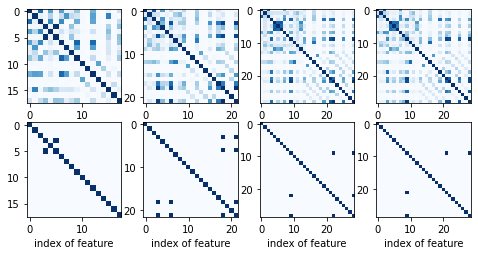

In [91]:
corr_mat_0 = np.ma.corrcoef(new_data_list[0], rowvar=False)
corr_mat_1 = np.ma.corrcoef(new_data_list[1], rowvar=False)
corr_mat_2 = np.ma.corrcoef(new_data_list[2], rowvar=False)
corr_mat_3 = np.ma.corrcoef(new_data_list[3], rowvar=False)

corr_mat_list = [corr_mat_0, corr_mat_1, corr_mat_2, corr_mat_3]

fig = plt.figure(figsize=(8, 8))
for i in range(1, 5):
    fig.add_subplot(4, 4, i)
    plt.imshow(np.abs(corr_mat_list[i - 1]), cmap='Blues')
    plt.xlabel('index of feature')
    #plt.ylabel('index of feature')
    #plt.savefig('../figs/corr_matrices.png', bbox_inches='tight')  
    
for i, corr in enumerate(corr_mat_list):
    corr_mat_list[i][corr <= 0.9] = 0
    corr_mat_list[i][corr > 0.9] = 1

for i in range(5, 9):
    fig.add_subplot(4, 4, i)
    plt.imshow(np.abs(corr_mat_list[i - 5]), cmap='Blues')
    plt.xlabel('index of feature')
    #plt.ylabel('index of feature')
    plt.savefig('../figs/corr_matrices.png', bbox_inches='tight')  
plt.show() 
#plt.imshow(np.abs(corr_mat), cmap='Blues')
#plt.colorbar()
#plt.show()

In [96]:
corr_indices = np.argwhere(np.abs(np.triu(corr_mat - np.eye(30))) > 0.8)
print(corr_indices)

[[ 0  2]
 [ 3  9]
 [ 3 23]
 [ 3 29]
 [ 4  5]
 [ 9 21]
 [ 9 23]
 [ 9 29]
 [21 29]
 [22 29]
 [23 29]
 [26 29]]


In [97]:
unique_ind1 = np.unique(corr_indices[:, 0])
unique_ind2 = np.unique(corr_indices[:, 1])
print(unique_ind1, unique_ind2)

[ 0  3  4  9 21 22 23 26] [ 2  5  9 21 23 29]


In [98]:
len1 = len(unique_ind1)
len2 = len(unique_ind2)
corr_ind_reduce_short = (unique_ind1, unique_ind2)[len(unique_ind1) > len(unique_ind2)]
corr_ind_reduce_big = (unique_ind1, unique_ind2)[len(unique_ind1) < len(unique_ind2)]
corr_ind_to_keep = []
for ind in corr_ind_reduce_short:
    is_in = np.isin(ind, corr_ind_reduce_big)
    if not is_in:
        corr_ind_to_keep.append(ind)

In [99]:
all_ind = np.unique(corr_indices.flatten())
print(all_ind.shape)

(11,)


In [100]:
corr_ind_to_throw = np.setdiff1d(all_ind, corr_ind_to_keep)

In [101]:
np.array(corr_ind_to_keep), corr_ind_to_throw

(array([ 2,  5, 29]), array([ 0,  3,  4,  9, 21, 22, 23, 26]))

In [107]:
keep, throw = feature_selection(new_data, 0.8)

In [108]:
keep, throw

(array([ 2,  5, 29]), array([ 0,  3,  4,  9, 21, 22, 23, 26]))

In [19]:
ind = np.array((rmv_ind[0], rmv_ind[1]))
print(ind)

[array([ 4,  5,  6,  8, 12, 22, 23, 24, 25, 26, 27, 28, 29])
 array([ 3,  4,  5,  6,  9, 12, 22, 23, 26, 27, 28])]


/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [6]:
ws = load_csv_data('../sgd_model_split.csv')

ValueError: Some errors were detected !
    Line #3 (got 29 columns instead of 21)
    Line #4 (got 28 columns instead of 21)